In [22]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.tensorboard.writer import SummaryWriter

from torch.utils.checkpoint import checkpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
import scipy.stats as stats
from pyDOE import lhs

from collections import OrderedDict
from tqdm import tqdm

import utils
import time
import os
import glob

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Torch utilizing dev", device)

Torch utilizing dev cuda:0


In [4]:
# constants and parameters
c = 299792458  # [m/s]
lambda_c = 1030e-9 
fr = 0.18

# parameters
t_fwhm = 50e-15 
peak_power = 25e3 

# fiber parameters
beta2 = -8.9655e-27 # [s^2/m]
beta3 = 80.3570e-42 # [s^3/m]
beta4 = -103.2412e-57 # [s^4/m]
beta5 = 110.2014e-72 # [s^5/m]
n0 = 1.44
n2 = 2.74e-20
R = 25e-6 
Aeff = 7.55e-12
tau_r = 0.1

# derived parameters
w = 2 * np.pi  *c / lambda_c # [Hz]
gamma = n2 * w/ (c*Aeff)
t_0 = t_fwhm / (2 * np.sqrt(2 * np.log(2)))
L_D = t_0 ** 2 / abs(beta2)
L_NL = 1 / (gamma * peak_power)
N_2 = L_D / L_NL
k0 = w * n0 / c
ss = 1 / (w * t_0)

# Raman parameters
tau1 = 0.0122e-12; tau2 = 0.032e-12


fiber_length = 25 * L_D
time_window = 10 * t_0

print(f'Fiber Length: {fiber_length} [m]')
print(f'Time Window: {time_window * 1e12} [ps]')

Fiber Length: 1.2571585530026246 [m]
Time Window: 0.21233045007200477 [ps]


# Create samples for training

In [2]:
def raman_response(t):
    comp_pos=[56.25,100.00,231.25,362.50,463.00,497.00,611.50,691.67,793.67,835.50,930.00,1080.00,1215.00]*100
    peak_int=[1.00,11.40,36.67,67.67,74.00,4.50,6.80,4.60,4.20,4.50,2.70,3.10,3.00]
    gau_FWHM=[52.10,110.42,175.00,162.50,135.33,24.50,41.50,155.00,59.50,64.30,150.00,91.00,160.00]*100
    lor_FWHM=[17.37,38.81,58.33,54.17,45.11,8.17,13.83,51.67,19.83,21.43,50.00,30.33,53.33]*100

    c = 299792458  # Speed of light in vacuum, m/s
    tr = torch.zeros_like(t)
    for b in range(len(comp_pos)):
        tr += peak_int[b] * torch.exp(-np.pi * c * t * lor_FWHM[b]) \
            * torch.exp(-((np.pi * c * gau_FWHM[b])**2) * (t**2) / 4) \
            * torch.sin(2 * np.pi * c * comp_pos[b] * t)
    tr /= torch.trapz(tr, t)
    return tr

In [26]:
class NLSE_Initial(Dataset):
    def __init__(self, sample_size):            
        gauss_func = lambda T: np.exp(-(T**2)/(2*(t_fwhm/2.35482)**2))
        t_pulse = (lhs(1, samples=sample_size//2) * 4 * t_fwhm - t_fwhm)
        t_pad = (lhs(1, samples=sample_size//4) * 2 * time_window - time_window)
        t = np.concatenate((t_pad, t_pulse, t_pad))
        # t = np.linspace(-time_window, time_window, sample_size)
        A = gauss_func(t)
        self.t = torch.tensor(t/t_0, requires_grad=True).float()
        self.A = torch.squeeze(torch.stack((
            torch.tensor(A).float(),
            torch.zeros((len(self.t),1))),1))
        return
    def __getitem__(self,idx):
        return self.t[idx], self.A[idx]
    def __len__(self):
        return len(self.t)
    def getall(self):
        return self.t, self.A

class NLSE_Boundary(Dataset):
    def __init__(self, sample_size):
        samples_half = sample_size//2
        self.z = torch.tensor(np.squeeze(lhs(1,samples=samples_half)*fiber_length)/L_D, requires_grad=True).float()
        return
    def __getitem__(self,idx):
        return self.z[idx]
    def __len__(self):
        return len(self.z)
    def getall(self):
        return self.z

# class NLSE_Raman(Dataset):
#     def __init__(self, sample_size):
#         t = torch.tensor(np.linspace(-time_window, time_window, sample_size), requires_grad=True).float()
#         RT = (tau1**2+tau2**2)/tau1/tau2**2*np.exp(-t/tau2)*np.sin(-t/tau1)
#         self.t = t/t_0
#         self.raman = raman_response(t)
#         return
#     def __getitem__(self,idx):
#         return self.t[idx], self.raman[idx]
#     def __len__(self):
#         return len(self.t)
#     def getall(self):
#         return self.t, self.raman

class NLSE(Dataset):
    def __init__(self, sample_size): # returns t, x
        t = (lhs(1,samples=sample_size) * 2 * time_window - time_window)
        t = torch.tensor(t/t_0, requires_grad=True).float()
        z = torch.tensor((lhs(1,samples=sample_size)*fiber_length)/L_D,requires_grad=True).float()
        
        self.X = torch.squeeze(torch.dstack((t, z))).float()
        return 
    def __getitem__(self,idx):
        return self.X[idx]
    def __len__(self):
        return len(self.X)
    def getall(self):
        return self.X

In [27]:
initial_samples = 1024
boundary_samples = 1024
training_samples = 25000

NLSE_boundary_ds = NLSE_Boundary(sample_size=boundary_samples)
NLSE_initial_ds = NLSE_Initial(sample_size=initial_samples)
NLSE_initial_dl = DataLoader(NLSE_initial_ds, batch_size=256, shuffle=True)
NLSE_ds = NLSE(sample_size=training_samples)
NLSE_dl = DataLoader(NLSE_ds, batch_size=256, shuffle=True)

In [27]:
torch.save(NLSE_boundary_ds, 'dataset/NLSE_boundary_ds.pth')
torch.save(NLSE_initial_ds, 'dataset/NLSE_initial_ds.pth')
torch.save(NLSE_ds, 'dataset/NLSE_ds.pth')

# Load dataset

In [5]:
NLSE_boundary_ds = torch.load('dataset/NLSE_boundary_ds.pth')
NLSE_initial_ds = torch.load('dataset/NLSE_initial_ds.pth')
NLSE_ds = torch.load('dataset/NLSE_ds.pth')
NLSE_dl = DataLoader(NLSE_ds, batch_size=4096, shuffle=True)

# Visualize dataset

Time sample shape: torch.Size([1024, 1]), Amplitude sample shape: torch.Size([1024, 2])


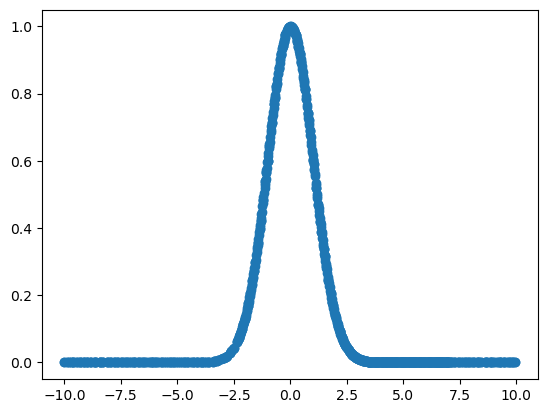

In [28]:
# Plot the initial condition
t_sample, A_sample = NLSE_initial_ds.getall()
print(f'Time sample shape: {t_sample.shape}, Amplitude sample shape: {A_sample.shape}')
plt.scatter(t_sample.detach().numpy(), A_sample[:, 0].detach().numpy())

Boundary sample shape: torch.Size([512])


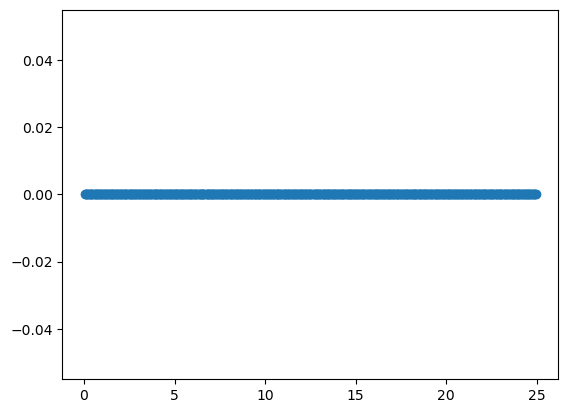

In [29]:
# Plot the boundary condition
z_sample = NLSE_boundary_ds.getall()
print(f'Boundary sample shape: {z_sample.shape}')
plt.scatter(z_sample.detach().numpy(), np.zeros_like(z_sample.detach().numpy()))

# Deep Neural Network Constructor

## With adaptive tanh activation function

In [11]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # define activation function
        # self.activation = torch.nn.Tanh
        self.activation = utils.AdaptiveTanh(adaptive_rate=1.0)
        
        # set up layer order dict
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation))
        
        # output layer
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
        # initialize weights using Xavier 
        for m in self.layers.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
        
    # forward pass
    def forward(self, x):
        out = self.layers(x)
        return out

## With swish activation function

In [88]:
# the deep neural network
class DNN_swish(torch.nn.Module):
    def __init__(self, layers):
        super(DNN_swish, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # define activation function
        # self.activation = torch.nn.Tanh
        self.activation = torch.nn.SiLU()
        
        # set up layer order dict
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation))
        
        # output layer
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
        # initialize weights using Xavier 
        for m in self.layers.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
        
    # forward pass
    def forward(self, x):
        out = self.layers(x)
        return out

# PINN

In [30]:
class PINN():
    def __init__(self, layers, initial_dl, boundary_ds, nlse_dl):
        # Initialize the dataset
        self.set_dataset(initial_dl, boundary_ds, nlse_dl)

        # Initialize the DNN
        self.dnn = DNN(layers).to(device)

        # Initialize the optimizer
        self.optimizer_adam = optim.Adam(self.dnn.parameters(), lr=0.0005)
        self.scheduler_adam = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer_adam, patience=50, factor=0.5, threshold=1e-8)
        self.optimizer_lbfgs = optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=100,
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change = float(1.0 * np.finfo(float).eps),
            line_search_fn="strong_wolfe"
        )
        self.scheduler_lbfgs = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer_lbfgs, patience=0, factor=0.5, threshold=1e-8)
        self.loss_history = []
        self.initial_loss_value = 0
        self.residual_loss_value = 0
        self.boundary_loss_value = 0

    def set_dataset(self, initial_dl, boundary_ds, nlse_dl):
        self.initial_dl = initial_dl
        self.boundary_ds = boundary_ds.getall().to(device)
        self.nlse_dl = nlse_dl

    # Forward pass
    def forward(self, X):
        return self.dnn.forward(X)
    
    def DNN(self, t, z):
        X = torch.cat((t, z), 1).float().to(device)
        return self.dnn.forward(X)

    # Normalization function for complex valued function
    def norm(self, real, imag):
        return torch.sqrt((real**2) + (imag**2))

    # Calculate loss due to initial condition
    def initial_loss(self):
        losses = []
        for T_0_batch, A_0_batch in self.initial_dl:
            T_0, A_0 = T_0_batch.to(device), A_0_batch.to(device)
            # Load initial condition
            zeros = torch.zeros((len(T_0), 1)).float().to(device)

            # Calculate the output of the DNN
            E_0 = self.DNN(T_0, zeros)

            loss = torch.mean((A_0 - E_0)**2)
            losses.append(loss)
        # Calculate the loss 
        J_0 = torch.mean(torch.stack(losses))
        return J_0

    # Calculate loss due to residual
    def residual_loss(self):
        # Load the dataset
        # X = self.nlse_ds.getall()
        losses = []
        for X_batch in self.nlse_dl:
            X = X_batch.to(device)
            t = torch.unsqueeze(X[:,0], 1)
            z = torch.unsqueeze(X[:,1], 1)

            # Calculate the output of the DNN
            E = self.DNN(t, z)

            # Split the real and imaginary part of the output
            E_re = torch.unsqueeze(E[:,0],1)
            E_im = torch.unsqueeze(E[:,1],1)
            E2 = E_re**2 + E_im**2
            
            # Calculate the derivatives
            E_ft_re = grad(outputs=E_re, inputs=t, grad_outputs=torch.ones_like(E_re), create_graph=True)[0]
            E_ftt_re = grad(outputs=E_ft_re, inputs=t, grad_outputs=torch.ones_like(E_ft_re), create_graph=True)[0]
            E_fttt_re = grad(outputs=E_ftt_re, inputs=t, grad_outputs=torch.ones_like(E_ftt_re), create_graph=True)[0]        
            E_ftttt_re = grad(outputs=E_fttt_re, inputs=t, grad_outputs=torch.ones_like(E_fttt_re), create_graph=True)[0]        
            # E_fttttt_re = grad(outputs=E_ftttt_re, inputs=t, grad_outputs=torch.ones_like(E_ftttt_re), create_graph=True)[0]
            E_fz_re = grad(outputs=E_re, inputs=z, grad_outputs=torch.ones_like(E_re), create_graph=True)[0]
            
            E_ft_im = grad(outputs=E_im, inputs=t, grad_outputs=torch.ones_like(E_im), create_graph=True)[0]
            E_ftt_im = grad(outputs=E_ft_im, inputs=t, grad_outputs=torch.ones_like(E_ft_im), create_graph=True)[0]
            E_fttt_im = grad(outputs=E_ftt_im, inputs=t, grad_outputs=torch.ones_like(E_ftt_im), create_graph=True)[0]
            E_ftttt_im = grad(outputs=E_fttt_im, inputs=t, grad_outputs=torch.ones_like(E_fttt_im), create_graph=True)[0]
            # E_fttttt_im = grad(outputs=E_ftttt_im, inputs=t, grad_outputs=torch.ones_like(E_ftttt_im), create_graph=True)[0]
            E_fz_im = grad(outputs=E_im, inputs=z, grad_outputs=torch.ones_like(E_im), create_graph=True)[0]

            # f_re = (E_fz_re) + (0.5 * beta2 * E_ftt_re) + N_2 * (((E_re**2)+(E_im**2))*E_im)   - (1/120 * beta5 * E_fttttt_re) 
            # f_im = (E_fz_im) - (0.5 * beta2 * E_ftt_im) - N_2 * (((E_re**2)+(E_im**2))*E_re) - (1/120 * beta5 * E_fttttt_im)
            E2_ft =  grad(outputs = (E2), inputs = t, grad_outputs=torch.ones_like(E_re), create_graph=True)[0]
            E2_ft_re = grad(outputs = ((E2) * E_re), inputs = t, grad_outputs=torch.ones_like(E_re), create_graph=True)[0]
            E2_ft_im = grad(outputs = ((E2) * E_im), inputs = t, grad_outputs=torch.ones_like(E_re), create_graph=True)[0]

            # Calculate the residuals
            f_re = (E_fz_re) - (0.5 * beta2 * E_ftt_im) - (1/6 * beta3 * E_fttt_re) - (1/24 * beta4 * E_ftttt_im)  + N_2 * ((E2) * E_im + ss * E2_ft_re - tau_r * E2_ft * E_im)           
            f_im = (E_fz_im) + (0.5 * beta2 * E_ftt_re) - (1/6 * beta3 * E_ftt_im) + (1/24 * beta4 * E_ftttt_re)  - N_2 * ((E2) * E_re - ss * E2_ft_im - tau_r * E2_ft * E_re)
            
            loss = torch.mean(self.norm(f_re, f_im)**2)
            losses.append(loss)
            torch.cuda.empty_cache()
        
        J_f = torch.mean(torch.stack(losses))
        return J_f
    
    def boundary_loss(self):
        # # Boundary conditions
        z_b = torch.unsqueeze(self.boundary_ds, 1)
        t_b = torch.ones((len(z_b),1), requires_grad=True).to(device) * time_window
        E_ub = self.DNN(t_b, z_b)
        E_lb = self.DNN(-t_b, z_b)

        E_ub_re = E_ub[:,0]
        E_lb_re = E_lb[:,0]
        E_ub_im = E_ub[:,1]
        E_lb_im = E_lb[:,1]

        E_ub_re_dt = grad(outputs=E_ub_re, inputs=t_b, grad_outputs=torch.ones_like(E_ub_re), create_graph=True)[0]
        E_ub_im_dt = grad(outputs=E_ub_im, inputs=t_b, grad_outputs=torch.ones_like(E_ub_im), create_graph=True)[0]

        E_lb_re_dt = grad(outputs=E_lb_re, inputs=t_b, grad_outputs=torch.ones_like(E_lb_re), create_graph=True)[0]
        E_lb_im_dt = grad(outputs=E_lb_im, inputs=t_b, grad_outputs=torch.ones_like(E_lb_im), create_graph=True)[0]
        
        E_b_re_err = torch.unsqueeze(E_ub_re - E_lb_re,1)
        E_b_im_err = torch.unsqueeze(E_ub_im - E_lb_im,1)

        E_b_re_dt_err = E_ub_re_dt - E_lb_re_dt
        E_b_im_dt_err = E_ub_im_dt - E_lb_im_dt

        E_b_err = (E_b_re_err**2) + (E_b_im_err**2)
        E_b_dt_err = (E_b_re_dt_err**2) + (E_b_im_dt_err**2)

        J_B = torch.mean((E_b_err**2) + (E_b_dt_err**2))
        return J_B
    
    # Calculate the loss
    def loss(self):
        self.initial_loss_value = self.initial_loss()
        self.residual_loss_value = self.residual_loss()
        self.boundary_loss_value = self.boundary_loss()
        loss = self.initial_loss_value + self.residual_loss_value + self.boundary_loss_value
        return loss
    
    # Train the model using Adam optimizer    
    def train_adam(self, nIter, display_freq, save = True, save_freq = 100,\
                    use_tensorboard = False, tensorboard_freq = 10):
        self.dnn.train()
        
        history = []
        epoch_hist = []
        writer = SummaryWriter() if use_tensorboard else None

        for epoch in range(0, nIter):
            # Backward pass
            self.dnn.zero_grad()
            loss = self.loss()
            loss.backward()
            self.optimizer_adam.step()
            self.scheduler_adam.step(loss)

            # Check if loss is nan
            if np.isnan(loss.item()):
                print("Error: Loss is nan, reloading model and stopping training")
                self.load_model('model/model_autosave.pth')
                return
            
            # Log the loss to tensorboard
            if epoch % tensorboard_freq == 0:                
                writer.add_scalar('loss/residual', self.initial_loss_value.item(), epoch)
                writer.add_scalar('loss/initial', self.residual_loss_value.item(), epoch)
                writer.add_scalar('loss/boundary', self.boundary_loss_value.item(), epoch)
                writer.add_scalar('loss/train', loss.item(), epoch)
                writer.add_scalar('learning_rate', self.optimizer_adam.param_groups[0]['lr'], epoch)
                torch.cuda.empty_cache()

            # Print the loss
            if epoch % display_freq == 0:
                print("Epoch", epoch, "~ Train Loss" , loss.item())
                history.append(loss.item())
                self.loss_history.append(loss)
                epoch_hist.append(epoch)

            # Save the model
            if save == True and epoch % save_freq == 0:
                self.save_model('model/model_autosave.pth')

        print("Final Loss: ", loss)
        return epoch_hist, history

    # Train the model using L-BFGS optimizer
    def train_lbfgs(self, nIter, display_freq, save = True, save_freq = 100,\
                    use_tensorboard = False, tensorboard_freq = 10):
        self.dnn.train()

        def closure():
            self.dnn.zero_grad()
            loss = self.loss()
            loss.backward()
            return loss
        
        history = []
        epoch_hist = []        
        writer = SummaryWriter() if use_tensorboard else None

        for epoch in range(0, nIter):
            loss = self.optimizer_lbfgs.step(closure)
            self.scheduler_lbfgs.step(loss)

            # Check if loss is nan
            if np.isnan(loss):
                print("Error: Loss is nan, reloading model and stopping training")
                self.load_model('model/model_autosave.pth')
                return
            
            if epoch % tensorboard_freq == 0:
                writer.add_scalar('loss/residual', self.initial_loss_value.item(), epoch)
                writer.add_scalar('loss/initial', self.residual_loss_value.item(), epoch)
                writer.add_scalar('loss/boundary', self.boundary_loss_value.item(), epoch)
                writer.add_scalar('loss/train', loss.item(), epoch)
                writer.add_scalar('learning_rate', self.optimizer_lbfgs.param_groups[0]['lr'], epoch)
                torch.cuda.empty_cache()
                torch.cuda.empty_cache()

            if(epoch % display_freq == 0):
                print("Epoch", epoch, "~ Train Loss" , loss)
                history.append(loss)
                self.loss_history.append(loss)
                epoch_hist.append(epoch)
                
            if save == True and epoch % save_freq == 0:
                self.save_model('model/model_autosave.pth')

        print("Final Loss: ", loss)
        return epoch_hist, history
    
    # save the model
    def save_model(self, path):
        torch.save(self.dnn.state_dict(), path)

    # autosave the model during training
    def autosave(self, epoch):
        # Save the model with epoch number in the filename
        filename = f'model/model_autosave_{epoch}.pth'
        torch.save(self.dnn.state_dict(), filename)

        # Get a list of all saved model files
        files = glob.glob('model/model_autosave_*.pth')

        # If there are more than 5 files, delete the oldest one
        if len(files) > 10:
            files.sort(key=os.path.getmtime)
            os.remove(files[0])
    
    # load the latest model
    def load_latest_model(self):
        # Get a list of all saved model files
        files = glob.glob('model/model_autosave_*.pth')

        # If there are no files, return None
        if not files:
            return None

        # Sort the files by modification time
        files.sort(key=os.path.getmtime)

        # Load the most recent file
        state_dict = torch.load(files[-1])

        # Apply the state dict to the current model
        self.dnn.load_state_dict(state_dict)
        
    # load the model
    def load_model(self, path):
        self.dnn.load_state_dict(torch.load(path))

# Initialize model

In [24]:
layers = layers = [2, 80, 80, 80, 80, 2]
_nn = PINN(layers=layers, initial_dl = NLSE_initial_dl, boundary_ds=NLSE_boundary_ds, nlse_dl = NLSE_dl)

In [60]:
# Load the model
_nn.load_model('model/model_manualsave.pth')

# Training

In [31]:
epochs, hist = _nn.train_adam(nIter=1000, display_freq=100, save=True, save_freq=10, use_tensorboard=True, tensorboard_freq=10)

plt.plot(epochs, hist)
plt.xlabel("Epochs")
plt.ylabel("Sum of MSE Loss") 
plt.title("PINN Train Loss")
plt.show() 

Epoch 0 ~ Train Loss 1730.499755859375


In [ ]:
epochs, hist = _nn.train_lbfgs(nIter=100, display_freq=10, save=True, save_freq=5, use_tensorboard=True, tensorboard_freq=10)

plt.plot(epochs, hist)
plt.xlabel("Epochs")
plt.ylabel("Sum of MSE Loss") 
plt.title("PINN Train Loss")
plt.show() 

In [62]:
# Save the model
_nn.save_model('model/model_manualsave.pth')

# Inference

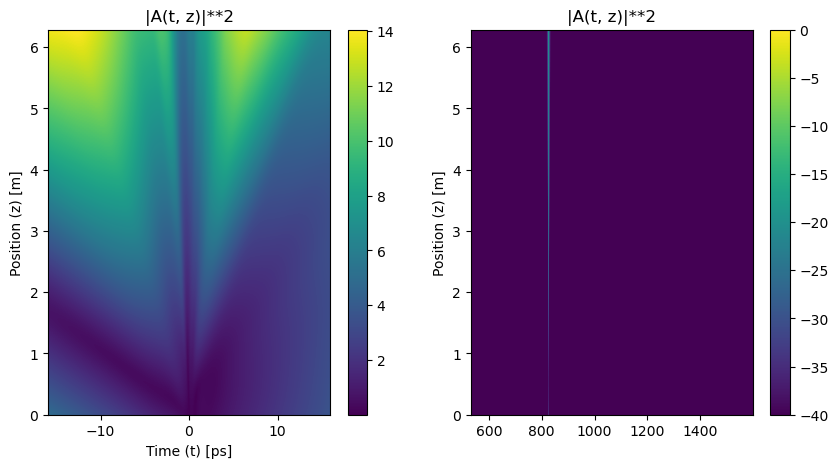

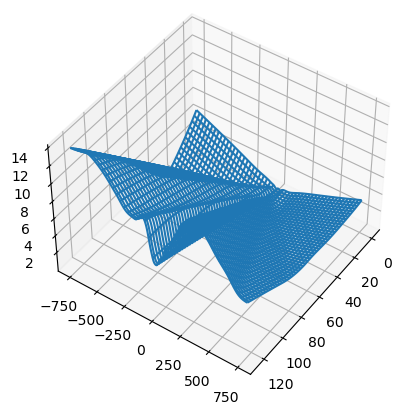

Text(0, 0.5, '|A(t, z)|')

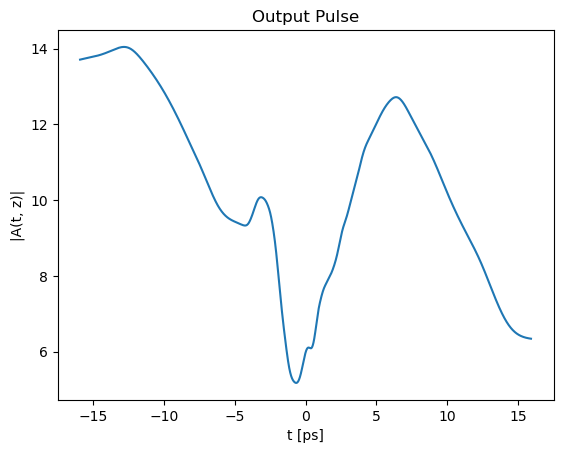

In [93]:
%matplotlib inline
time_width = 15 * 1e-12
timesteps = 8192
tres = time_width / timesteps
t = np.linspace(-time_window, time_window, timesteps)
z = np.linspace(0, 5 * fiber_length/L_D, 200)

cfreq = c / lambda_c
fs = 1 / time_width
freq = cfreq + fs * np.linspace(-timesteps / 2, timesteps / 2, num=timesteps)
wave = c / freq 

t_in = t / t_0
z_in = z / L_D
T, Z = np.meshgrid(t_in, z)

_X = torch.tensor(np.dstack((T, Z))).float().to(device)

A_pred = _nn.forward(_X).to('cpu').detach().numpy()

A_norm = np.sqrt((A_pred[:,:,0] ** 2) + (A_pred[:,:,1] ** 2))
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
im = ax.imshow(A_norm, aspect='auto', origin='lower', extent=[T.min() * t_0 * 1e12, T.max() * t_0 * 1e12, Z.min() * L_D, Z.max() * L_D])
plt.colorbar(im)
plt.title('|A(t, z)|**2')
plt.ylabel("Position (z) [m]")
plt.xlabel("Time (t) [ps]")

A_complex = A_pred[:,:,0] + 1j*A_pred[:,:,1]
A_pred_f = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(A_complex), axes=(1 )))**2)
mlIW = np.max(np.max(A_pred_f))  # max value, for scaling plot
iis = (wave > 450 * 1e-9) & (wave < 1600 * 1e-9)  # wavelength grid

# A_pred_f = A_pred_f / np.max(A_pred_f)
ax = fig.add_subplot(122)
im = ax.imshow(A_pred_f[:, iis]-mlIW, aspect='auto', origin='lower', extent=[wave[iis].min() * 1e9, wave[iis].max()* 1e9, Z.min() * L_D, Z.max()*  L_D], vmin = -40, vmax=0)
plt.colorbar(im)
plt.title('|A(t, z)|**2')
plt.ylabel("Position (z) [m]")
# plt.xlabel("Time (t) [ps]")
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_wireframe(Z, T, A_norm, cmap='binary')
ax.view_init(45, 35)
plt.show()

t_slice = t[:]*t_0*1e12
A_slice = A_norm[-1,:]

# plt.ylim(0, time_window/t_0)

plt.plot(t_slice, A_slice)
plt.title('Output Pulse')
plt.xlabel('t [ps]')
plt.ylabel('|A(t, z)|')